# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

2024-05-20 22:22:49.985958: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 22:22:50.010783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 22:22:50.415110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
data = np.load('/home/josea/PracticaTimingDigital/pulso_Co60_filt_norm.npz')
pulsos_Co60_practica_ = data['data']

In [4]:
from functions import get_mean_pulse_from_set, pulso, momentos, gauss, gauss_fit, delay_pulse_pair, move_to_reference

# **PREPROCESSING**

In [5]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28,  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55,  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82,  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [6]:
#------------------------------------- Basic definitions ----------------------------------------
Ncasos = 300
Nc = 2

t = np.linspace(0,Nt,Nt_new)
t0 = 70 + np.random.randint(8, size=Ncasos) 

# **GENERATE MEAN PULSE PER DETECTOR**

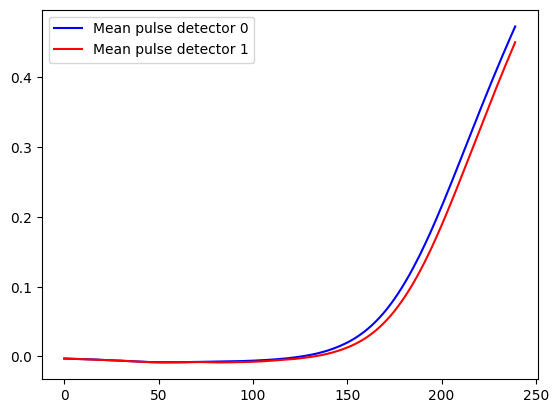

In [7]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_V55, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_V55, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **DETECTOR 0**

Text(0, 0.5, 'Voltage [A.U]')

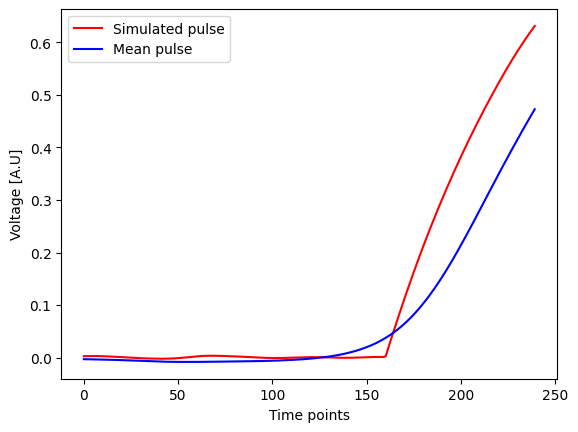

In [12]:
pulso_original_dec0 = pulso(t,70, tau_rise = 15)

plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [13]:
#------------------------------ Create simulated pairs ---------------------------------
INPUT_dec0 = np.zeros((Ncasos,Nt_new,Nc))
for i in range(Ncasos):
  centro = t0[i]
  PULSO = pulso(t, centro,  tau_rise = 15)
  INPUT_dec0[i,:,0] = PULSO
  INPUT_dec0[i,:,1] = PULSO

#------------------------------ Create a pair of mean pulses ----------------------------
Ncasos_mean = 100
INPUT2_dec0 = np.zeros((Ncasos_mean,len(mean_pulse_dec0), 2))
INPUT2_dec0[:,:,0] = mean_pulse_dec0
INPUT2_dec0[:,:,1] = mean_pulse_dec0

In [14]:
#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = delay_pulse_pair(INPUT_dec0, new_time_step, t_shift = 0, delay_steps = 32, NOISE = True)

#--------------------------------- Delay mean pulse ----------------------------------------------------
INPUT2_dec0, REF2_dec0 = delay_pulse_pair(INPUT2_dec0, new_time_step, t_shift = 0, delay_steps = 32, NOISE = True)

#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0[:,start:stop,:], INPUT2_dec0[:,start:stop,:]), axis = 0)
REF_train_dec0 = np.concatenate((REF_dec0[:], REF2_dec0[:]))

In [15]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)


NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)

(400, 12, 2) NM = 12


# **DETECTOR 1**

Text(0, 0.5, 'Voltage [A.U]')

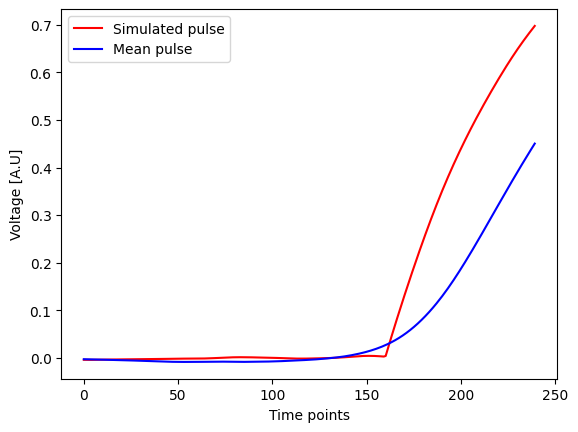

In [17]:
pulso_original_dec1 = pulso(t,70, tau_rise = 12)

plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [18]:
#------------------------------ Create simulated pairs ---------------------------------
Ncasos = 300
INPUT_dec1 = np.zeros((Ncasos,Nt_new,Nc))

for i in range(Ncasos):
  centro = t0[i]
  PULSO = pulso(t, centro, tau_rise = 12)
  INPUT_dec1[i,:,0] = PULSO
  INPUT_dec1[i,:,1] = PULSO

#------------------------------ Create a pair of mean pulses ----------------------------
Ncasos_mean = 100
INPUT2_dec1 = np.zeros((Ncasos_mean,len(mean_pulse_dec1), 2))
INPUT2_dec1[:,:,0] = mean_pulse_dec1
INPUT2_dec1[:,:,1] = mean_pulse_dec1


In [19]:
#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec1, REF_dec1 = delay_pulse_pair(INPUT_dec1, new_time_step, t_shift = 0, delay_steps = 32, NOISE = True)

#--------------------------------- Delay mean pulse ----------------------------------------------------
INPUT2_dec1, REF2_dec1 = delay_pulse_pair(INPUT2_dec1, new_time_step, t_shift = 0, delay_steps = 32, NOISE = True)

#--------------------------------- Create train set ----------------------------------------------------
trainX_dec1 = np.concatenate((INPUT_dec1[:,start:stop,:], INPUT2_dec1[:,start:stop,:]), axis = 0)
REF_train_dec1 = np.concatenate((REF_dec1[:], REF2_dec1[:]))

In [20]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)

(400, 12, 2) NM = 12


# **FULL TOF**

In [21]:
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec0[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)

M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)


M_V28 = momentos(new_V28[:,start:stop,:])
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(new_V55[:,start:stop,:])
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(new_V82[:,start:stop,:])
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)


(187, 12, 2)
(268, 12, 2)
(281, 12, 2)


In [22]:
def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))


  x1 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x2 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x3 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

In [33]:
epochs = 75
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 2e-3)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 2e-3)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0, epochs = 5, batch_size = 64, shuffle = True, verbose = 1)
     history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1, epochs = 5, batch_size = 64, shuffle = True, verbose = 1)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])
     
     TOFN_dec0_REF_V82 = model_dec0.predict([M_REF_dec0[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_REF_dec1[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,1]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_REF_dec0[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_REF_dec1[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,1]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_REF_dec0[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_REF_dec1[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,1]])


     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = -1*np.mean(TOFN_V28) + np.mean(TOFN_V55)
     centroid_V82 = -1*np.mean(TOFN_V82) + np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 173.1888
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 107.5186
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 55.2148
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 36.5320
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 25.9373
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 43.5031
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.8580 
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 25.8418
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 24.9044
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 23.5988
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 21.9425
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 20.97

(array([3]), array([53])) 0.07025114889553306


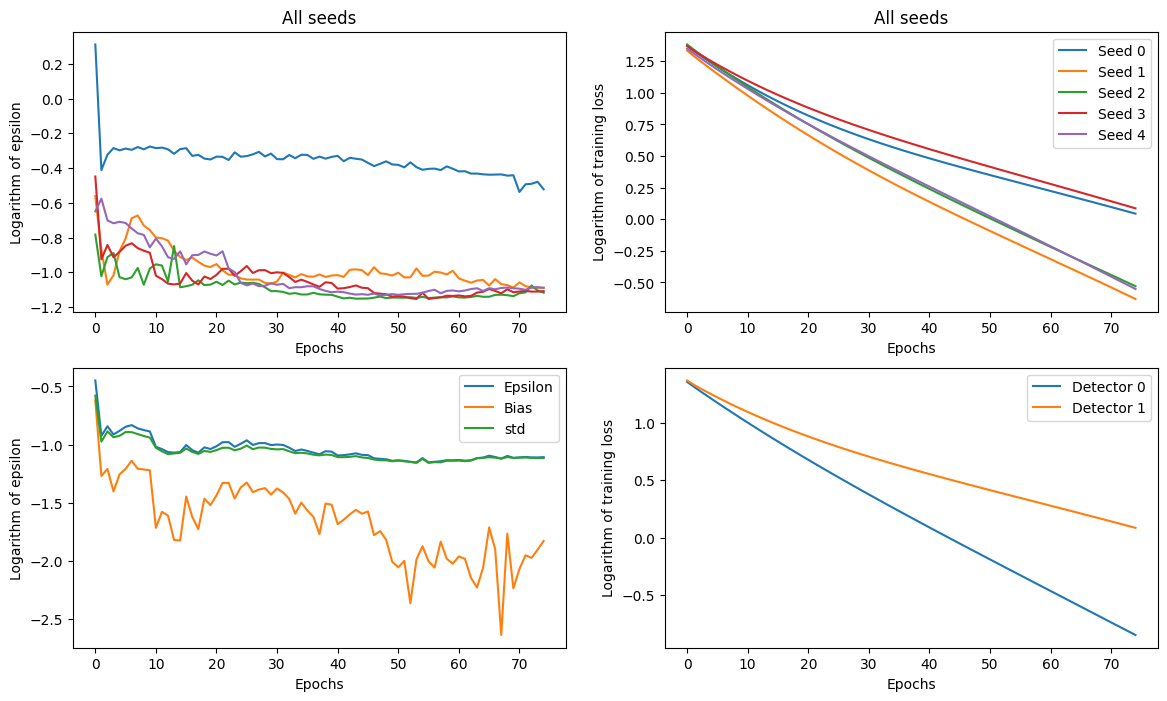

In [35]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 3
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  #plt.plot(np.log10(bias[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.178  FWHM(ns) = 0.179  std(ns) = 0.076
V55: CENTROID(ns) = 0.007  FWHM(ns) = 0.174  std(ns) = 0.074
V28: CENTROID(ns) = -0.195  FWHM(ns) = 0.153  std(ns) = 0.065


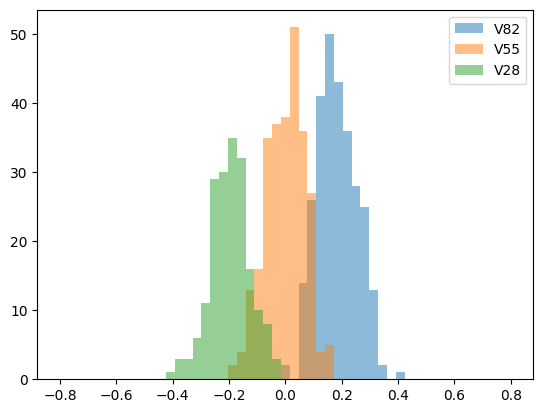

: 

In [36]:
epoch = 53
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_V82_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(TOFN_V55_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(TOFN_V28_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [32]:
Error_V82 = (-1*(TOFN_V82_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]) - 0.2)**2
Error_V55 = (-1*(TOFN_V55_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]))**2
Error_V28 = (-1*(TOFN_V28_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]) + 0.2)**2

Error = np.concatenate((Error_V82, Error_V55, Error_V28),axis=0)
MSE = np.mean(Error)   
print(MSE)                                                                                                               

0.005504045830122098


# **ENSEMBLE MODEL**

In [22]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)


V82: CENTROID(ns) = 0.185  FWHM(ns) = 0.191  std(ns) = 0.081
V55: CENTROID(ns) = 0.007  FWHM(ns) = 0.170  std(ns) = 0.072
V28: CENTROID(ns) = -0.213  FWHM(ns) = 0.198  std(ns) = 0.084


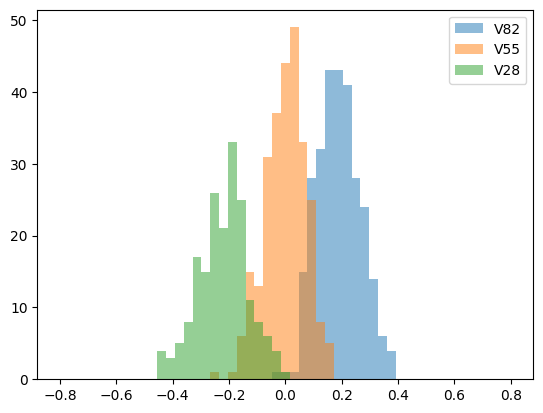

In [23]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(weighted_mean_V82) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(weighted_mean_V55) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(weighted_mean_V28) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))